<a href="https://colab.research.google.com/github/lhb00/basic_pytorch_for_deeplearning/blob/main/basic_pytorch_for_deeplearning_theme_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Theme 6. 합성곱 신경망
####2. AlexNet

In [3]:
# AlexNet은 2012년 ILSVRC 대회에서 우승을 차지한 합성곱 신경망, 가장 대표적인 CNN모델
# 원 논문에선 지금 안쓰이는 기술들이 적용됨, 따라서 파이토치에서는 이런 부분들을 수정하여 모델을 제공하고 있음. But, 여기서는 직접 작성할 거임.
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
# transforms.Normalize은 특정 평균, 표준편차를 따르는 정규분포를 통해 이미지를 표준화하는 방법
# CIFAR10은 3채널 컬러 이미지 => 각 장의 평균과 표준편차를 정함.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #첫 번째 (0.5, 0.5, 0.5)는 각 채널 당 평균을 할당한 것, 튜플로 입력
# 두 번째 (0.5, 0.5, 0.5)는 각 채널의 표준편차를 기입한 것. 평균과 표준편차는 학습 전에 가지고 있는 이미지로부터 계산, 여기서는 임의의 값 0.5 기입.
trainset = torchvision.datasets.CIFAR10(root = '/content/gdrive/My Drive/deeplearning/data', train = True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32, shuffle = True)

testset = torchvision.datasets.CIFAR10(root = '/content/gdrive/My Drive/deeplearning/data', train = False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #최근의 CNN은 깊고, 복잡 => 다수의 필터를 계산하고 업데이트해야함. =>GPU는 필수!, GPU 연산이 가능한지 확인하고, 비활성화 상태면 GPU 연산으로 옵션 변경
# + torch.device를 통해 GPU가 가능한 텐서로 연산 수행 가능.
print(f'{device} is available.') #GPU 사용 가능

cuda:0 is available.


In [6]:
# AlexNet은 ImageNet 데이터를 위하여 만들어짐. ImageNet은 1000개의 클래스로 분류된, 256x256 or 224x224 크기를 갖는 이미지 => 크기가 32x32인 CIFAR10 이미지는 제대로 동작 안할수도.
# 데이터에 맞게 필터의 크기와 보폭 수를 조정해 모델을 구축.
class AlexNet(nn.Module): # AlexNet 클래스 생성
  def __init__(self): # __init__ 함수에 구조 작성
    super(AlexNet, self).__init__()
    self.features = nn.Sequential( # nn.Sequentail 을 이용하면 순차적으로 행해지는 연산을 한 번에 묶기 O, nn.Sequential의 괄호 안은 작성 순서대로 연산 수행됨.
        nn.Conv2d(3, 64, 3), nn.ReLU(), # CIFAR10은 RGB 컬러 이미지 => 입력 채널의 수가 3이므로 반드시 nn.Conv2d에서 입력 채널 수에 3을 입력해야함.(nn.Conv2d(입력 채널 수 , 출력 채널 수, 필터의 크기))
        # 채널의 출력 크기는 임의로 정해줌. 보폭은 별도로 지정 X => 기본값 1로 진행됨. 다음 활성화 함수 nn.ReLU를 적용.
        nn.MaxPool2d(2,2), # 2X2 크기의 필터를 2칸씩 이동하는 최댓값 풀링 nn.MaxPool2d(필터의 크기, 보폭)을 시행.
        nn.Conv2d(64, 192, 3, padding = 1), nn.ReLU(), # 위와 동일한 방법으로 층을 쌓음. 다시 말하지만 이전 층의 출력값=다음 층의 입력값은 필수.
        # padding = 1은 해당 층의 입력 피쳐맵의 가장 외곽을 0으로 한 겹 둘러싼단 얘기. ex. 100X100 피쳐맵에 한 겹을 씌우면 102X102가 된다. 가장 외곽의 값은 0.
        # 외곽을 0으로 채우는 0 패드 이외에도 padding_mode를 통해 다른 패드 사용 가능('zeros', 'reflect', 'replicate, 'circular' 등.)
        nn.MaxPool2d(2,2),
        nn.Conv2d(192, 384, 3, padding = 1), nn. ReLU(),
        nn.Conv2d(384, 256, 3, padding=1), nn.ReLU(),
        nn.Conv2d(256, 256, 1), nn.ReLU(),
        nn.MaxPool2d(2,2))# self.features는 합성곱, 풀링 연산이 행해지는 피쳐 추출 부분임.
    
    self.classifier = nn.Sequential( # Fully- connected layer로 구성된 self.clasifier를 정의.
        nn.Dropout(0.5),
        nn.Linear(256*3*3, 1024), nn.ReLU(), # 처음 들어오는 입력값의 크기=self.features에서 나온 피쳐맵을 일렬로 편 벡터의 크기여야 함. 
        nn.Dropout(0.5),
        nn.Linear(1024, 512), nn.ReLU(),
        nn.Linear(512,10)) # CIFAR10은 10개의 클래스를 가진 데이터 => 마지막 노드 수는 10이 되어야 함. 나머지 노드 수나 드롭아웃은 사용자가 임의로 정할 수 있음.
    
  def forward(self,x):
    x = self.features(x)
    x = x.view(-1, 256*3*3)
    x = self.classifier(x)
    return x

In [7]:
# 다중 분류 문제에서는 Cross Entropy Loss를 기본으로 사용.
# pytorch에서 제공하는 Cross Entropy Loss는 softmax 계산까지 포함되어 있으므로 모델의 마지막 출력값에 별도의 softmax를 적용할 필요 X.
# + GPU 연산을 위해 모델을 불러올 땐 .to(device)를 반드시 붙일 것.
criterion = nn.CrossEntropyLoss()
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=1e-3)

In [11]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트
n = len(trainloader) # 배치 개수
for epoch in range(50):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device) # 배치 데이터, 모델의 학습 과정은 MLP와 동일, GPU 연산을 위해 .to(device)는 필수
    optimizer.zero_grad()
    outputs = alexnet(inputs) # 예측값 산출
    loss = criterion(outputs, labels) # 손실 함수 계산
    loss.backward() # 손실 함수 기준으로 역전파 선언
    optimizer.step() # 가중치 최적화
    running_loss += loss.item()

  loss_.append(running_loss/n)
  print('[%d] loss: %.3f'%(epoch + 1, running_loss / len(trainloader))) 

[1] loss: 2.303
[2] loss: 2.303
[3] loss: 2.303
[4] loss: 2.303
[5] loss: 2.303
[6] loss: 2.303
[7] loss: 2.303
[8] loss: 2.303
[9] loss: 2.303
[10] loss: 2.303
[11] loss: 2.303
[12] loss: 2.303
[13] loss: 2.303
[14] loss: 2.303
[15] loss: 2.303
[16] loss: 2.303
[17] loss: 2.303
[18] loss: 2.303
[19] loss: 2.303
[20] loss: 2.303
[21] loss: 2.303
[22] loss: 2.303
[23] loss: 2.303
[24] loss: 2.303
[25] loss: 2.303
[26] loss: 2.303
[27] loss: 2.303
[28] loss: 2.303
[29] loss: 2.303
[30] loss: 2.303
[31] loss: 2.303
[32] loss: 2.303
[33] loss: 2.303
[34] loss: 2.303
[35] loss: 2.303
[36] loss: 2.303
[37] loss: 2.303
[38] loss: 2.303
[39] loss: 2.303
[40] loss: 2.303
[41] loss: 2.303
[42] loss: 2.303
[43] loss: 2.303
[44] loss: 2.303
[45] loss: 2.303
[46] loss: 2.303
[47] loss: 2.303
[48] loss: 2.303
[49] loss: 2.303
[50] loss: 2.303


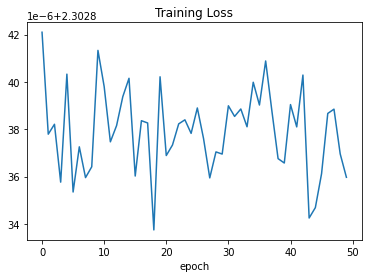

In [12]:
plt.plot(loss_)
plt.title("Training Loss")
plt.xlabel("epoch")
plt.show()

In [13]:
PATH = '/content/gdrive/My Drive/deeplearning/models/cifar_alexnet.pth' # 모델의 저장 경로, 모델명.pth 입력
torch.save(alexnet.state_dict(), PATH) # torch.save(alexnet.state_dict(), PATH)를 이용하여 모델을 저장

In [14]:
alexnet = AlexNet().to(device) # 모델 저장은 모델 통째로 저장 X, 모델 파라미터를 저장하는 것 => 저장된 모델을 불러올 때 모델이 선행적으로 선언되어 있어야만 함.
alexnet.load_state_dict(torch.load(PATH)) # 모델의 파라미터를 불러와 모델에 주입.

<All keys matched successfully>

In [15]:
correct = 0 # 데이터 전체, 정답 개수를 누적할 수 있는 변수 선언
total = 0
with torch.no_grad(): # 평가 시에는 requires_grad를 비활성화
  alexnet.eval() # 평가 시에는 dropout 등과 같은 정규화 작업 X => alexnet.eval()을 선언, 정규화 작업 비활성화
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = alexnet(images)
    _, predicted = torch.max(outputs, 1) # outputs는 크기가 (배치 크기)X10인 벡터 형태로 나옴. => 열 기준으로 가장 큰 원소의 위치가 라벨이 됨. => 최댓값을 열(1) 기준으로 계산, 예측값을 구한다.
    # torch.max는 최댓값, 최댓값의 위치를 산출해줌, But 우리는 최댓값은 필요 없으므로 안 받아도 됨 => _로 처리하여 출력값 저장 X, _, predicted는 최댓값의 위치만 predicted에 저장하겠다는 뜻!
    total += labels.size(0) # 개수 누적(총 개수)
    correct += (predicted==labels).sum().item() # 누적(맞으면 1, 틀리면 0으로 합산)

print('Test accuracy: %.2f %%'%(100 * correct /total))

Test accuracy: 9.97 %


####3. ResNet

In [31]:
class ResidualBlock(nn.Module):

  def __init__(self, in_channels, out_channnels, stride=1):
    super(ResidualBlock, self).__init__()
    self.stride = stride
    self.in_channels = in_channels
    self.out_channels = out_channnels
    self.conv_block = nn.Sequential( #컨볼루션 연산 2개를 포함한 블록 생성
        nn.Conv2d(self.in_channels, self.out_channels, kernel_size = 3, stride = stride,# 학습 속도 ↑가능한 배치 정규화를 층 사이에 적용, 배치 정규화는 각 배치의 평균, 분산을 이용해서 데이터를 정규화 시키는 방법.
                  padding=1, bias=False), nn.BatchNorm2d(self.out_channels), nn.ReLU(),
        nn.Conv2d(self.out_channels, self.out_channels, kernel_size = 3, stride = 1, padding =1,
                  bias = False), nn.BatchNorm2d(self.out_channels))
    if self.stride !=1 or self.in_channels !=self.out_channels: # ResNet은 ResidualBlock 하나를 거칠 때마다 이미지 사이즈가 줄어들고, 채널 수는 늘어나는 구조 => 처음 들어오는 x값, 블록을 거친 출력값 out의 크기가 같아야만 함. 
    # 따라서 차이가 나는 경우 출력값의 크기 = 입력값의 크기가 되도록 하기 위해 별도의 컨볼루션 연산을 진행, 입력 크기 = 출력 크기로 만든다.
      self.downsample = nn.Sequential(
          nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1,
                    stride=stride, bias=False), nn.BatchNorm2d(self.out_channels))
    def forward(self,x):
      out = self.conv_bloc(x)
      if self.stride != 1 or self.in_channels != self.out_channels: # 사이즈 조정이 필요할 시 입력값의 크기 조정
        x = self.downsample(x)
      out = F.relu(x + out) # Skip connection 시행
      return out

In [32]:
class ResNet(nn.Module): # ResNet 클래스 정의, __init__ 작성
  def __init__(self, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.base = nn.Sequential( # 입력 이미지가 들어와 연산을 수행하는 기본층 생성
        nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1, bias = False),
        nn.BatchNorm2d(64),
        nn.ReLU())
    self.layer1 = self._make_layer(64, num_blocks[0], stride=1) # 기본층 제외 4개의 블록 필요, self._make_layer을 이용, 4개의 블록 묶음 선언
    self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
    self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
    self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
    self.gap = nn.AvgPool2d(4) # 4: 필터 사이즈, 합성곱 층들을 지나 최종적으로 크기가 4X4인 피쳐맵 512개 나옴. 크기가 4X4인 평균 풀링을 이용, 각 피쳐맵 당 1개의 평균값 나옴, 성분이 512개인 벡터 얻음.
    self.fc = nn.Linear(512, num_classes) # 클래스가 10개인 이미지를 분류하는 것이므로 2**10=512개의 노드에서 10개의 노드로 가는 FC 정의.
  def _make_layer(self, out_channels, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1) # 블록의 반복 횟수만큼 stride 저장.
    layers = []
    for stride in strides:
      block = ResidualBlock(self.in_channels, out_channels, stride) # ResidualBlock을 불러와 append를 이용해 차례로 붙여줌. 이때 이전 출력 채널 크기 = 다음 입력 채널 크기여야 하므로
      layers.append(block)
      self.in_channels = out_channels # 본 코드를 작성.
    return nn.Sequential(*layers) # nn.Sequential에 넣어 모델 구축. 리스트는 길이에 상관 없이 모든 성분을 별도로 nn.Sequential에 전달하는 역할

In [33]:
# 마지막으로 ResNet 클래스 안에 연산을 행하는 forward를 정의
def forward(self,x):
  out = self.base(x)
  out = self.layer1(out)
  out = self.layer2(out)
  out = self.layer3(out)
  out = self.layer4(out)
  out = self.gap(out)
  out = out.view(out.size(0), -1)
  out = self.fc(out)
  return out

In [34]:
# 클래스를 불러오는 함수 생성. 각 모델마다 블록의 반복 횟수를 리스트로 정의하여 입력. => 18, 34 외 4개의 블록을 가진 레이어의 개수 조정 가능.
def modeltype(model):
  if model == 'resnet18':
    return ResNet([2,2,2,2])
  elif model == 'resnet34':
    return ResNet([3,4,6,3])

In [35]:
resnet = modeltype('resnet18').to(device)
print(resnet)
PATH = '/content/gdrive/My Drive/deeplearning/models/cifar_resnet.pth'

ResNet(
  (base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ResidualBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kerne

####4. 다양한 합성곱 신경망

In [ ]:
import torchvision.models as models # torchvision.models as models를 이용해 모델을 불러올 수 있음.
alexnet = models.alexnet().to(device) # Alexnet 모델 사용 => alexnet = models.alexnet().to(device) 선언하면 됨.
# 중요한 점은 제공 모델들이 클래스 개수가 1,000개인 ImageNet 데이터를 위해 만들어졌으므로, 모델의 최종 출력 노드 수가 1000개임. =>우리가 다루는 데이터의 클래스 수로 변경 필요
alexnet.classifier[6] = nn.Linear(4096,5) # 만약 5개의 클래스를 분류하는 문제라고 했을 때, AlexNet의 경우 마지막 층이 alexnet.classifier[6]이므로 alexnet.classifier[6] = nn.Linear(4096,5)로 재정의 하면 됨.
# 모델 마다 층의 이름/인덱스 다를 수 있다. model.named_parameters() 함수로 이름을 알아 낼 수 있고, 파이토치에서는 30여 개의 합성곱 신경망을 제공중이다.
"""
resnet18 = models.resnet18().to(device)
vgg16 =models.vgg16().to(device)
densenet = models.densenet161().to(device)
inception = modls.inception_v3().to(device)
googlenet = modls.googlenet().to(device)
shufflenet = models.shufflenet_v2_x1_0().to(device)
mobilenet_v2 = models.mobilenet_v2().to(device)
resNext50_32x4d = models.resnext50_32x4d().to(device)
wide_resnet50_2 = models.wide_resnet50_2().to(device)
mnasnet = models.mnasnet1_0().to(device)
"""